## Question5. Use the available variables to construct a model that predict delays.

In [1]:
import os
import requests
import sys
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import os.path
import bz2
import csv
import seaborn as sns

from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import udf
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler

from IPython.display import display
from IPython.html.widgets import interact

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, plot_confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline

C:\Users\juhyu\Anaconda3\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [2]:
# constant setting
os.chdir('C:\\Users\\juhyu\\OneDrive\\Desktop\\JH\\SIM\\Year2\\Programming for data science\\Coursework material\\dataverse_files')
airline2003=pd.read_csv('2003.csv.bz2', compression='bz2', low_memory=False,error_bad_lines=False,skiprows=lambda x: x%2 ==1)
airline2004=pd.read_csv('2004.csv.bz2', compression='bz2', low_memory=False,error_bad_lines=False,skiprows=lambda x: x%2 ==1)
airline2005=pd.read_csv('2005.csv.bz2', compression='bz2', low_memory=False,error_bad_lines=False,skiprows=lambda x: x%2 ==1)

C:\Users\juhyu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
frames=[airline2003,airline2004,airline2005]
df=pd.concat(frames)

In [ ]:
df1=df

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10379203 entries, 0 to 3570297
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     int64  
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             int64  
 20  TaxiOut            int64  
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay     

In [6]:
df.count()

Year                 10379203
Month                10379203
DayofMonth           10379203
DayOfWeek            10379203
DepTime              10197586
CRSDepTime           10379203
ArrTime              10178029
CRSArrTime           10379203
UniqueCarrier        10379203
FlightNum            10379203
TailNum              10366141
ActualElapsedTime    10178029
CRSElapsedTime       10379203
AirTime              10178029
ArrDelay             10178029
DepDelay             10197586
Origin               10379203
Dest                 10379203
Distance             10379203
TaxiIn               10379203
TaxiOut              10379203
Cancelled            10379203
CancellationCode       157652
Diverted             10379203
CarrierDelay          9042832
WeatherDelay          9042832
NASDelay              9042832
SecurityDelay         9042832
LateAircraftDelay     9042832
dtype: int64

In [7]:
df = df.drop(columns = ['CancellationCode'])

In [8]:
df = df.dropna()

In [9]:
df.count()

Year                 8867911
Month                8867911
DayofMonth           8867911
DayOfWeek            8867911
DepTime              8867911
CRSDepTime           8867911
ArrTime              8867911
CRSArrTime           8867911
UniqueCarrier        8867911
FlightNum            8867911
TailNum              8867911
ActualElapsedTime    8867911
CRSElapsedTime       8867911
AirTime              8867911
ArrDelay             8867911
DepDelay             8867911
Origin               8867911
Dest                 8867911
Distance             8867911
TaxiIn               8867911
TaxiOut              8867911
Cancelled            8867911
Diverted             8867911
CarrierDelay         8867911
WeatherDelay         8867911
NASDelay             8867911
SecurityDelay        8867911
LateAircraftDelay    8867911
dtype: int64

In [10]:
planedf = pd.read_csv('plane-data.csv')

In [11]:
planedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tailnum        5029 non-null   object
 1   type           4480 non-null   object
 2   manufacturer   4480 non-null   object
 3   issue_date     4480 non-null   object
 4   model          4480 non-null   object
 5   status         4480 non-null   object
 6   aircraft_type  4480 non-null   object
 7   engine_type    4480 non-null   object
 8   year           4480 non-null   object
dtypes: object(9)
memory usage: 353.7+ KB


In [12]:
planedf.columns = ['TailNum', 'Type', 'Manufacturer', 'IssueDate', 
                   'Model', 'Status', 'AircraftType', 'EngineType', 'Year']

In [13]:
pd = planedf.dropna()

In [14]:
pd.count()

TailNum         4480
Type            4480
Manufacturer    4480
IssueDate       4480
Model           4480
Status          4480
AircraftType    4480
EngineType      4480
Year            4480
dtype: int64

In [15]:
FullData = df.merge(pd, on='TailNum', how='left')

In [16]:
FullData.count()

Year_x               8867911
Month                8867911
DayofMonth           8867911
DayOfWeek            8867911
DepTime              8867911
CRSDepTime           8867911
ArrTime              8867911
CRSArrTime           8867911
UniqueCarrier        8867911
FlightNum            8867911
TailNum              8867911
ActualElapsedTime    8867911
CRSElapsedTime       8867911
AirTime              8867911
ArrDelay             8867911
DepDelay             8867911
Origin               8867911
Dest                 8867911
Distance             8867911
TaxiIn               8867911
TaxiOut              8867911
Cancelled            8867911
Diverted             8867911
CarrierDelay         8867911
WeatherDelay         8867911
NASDelay             8867911
SecurityDelay        8867911
LateAircraftDelay    8867911
Type                 5782426
Manufacturer         5782426
IssueDate            5782426
Model                5782426
Status               5782426
AircraftType         5782426
EngineType    

In [17]:
FullData = FullData.dropna()

In [18]:
FullData.count()

Year_x               5782426
Month                5782426
DayofMonth           5782426
DayOfWeek            5782426
DepTime              5782426
CRSDepTime           5782426
ArrTime              5782426
CRSArrTime           5782426
UniqueCarrier        5782426
FlightNum            5782426
TailNum              5782426
ActualElapsedTime    5782426
CRSElapsedTime       5782426
AirTime              5782426
ArrDelay             5782426
DepDelay             5782426
Origin               5782426
Dest                 5782426
Distance             5782426
TaxiIn               5782426
TaxiOut              5782426
Cancelled            5782426
Diverted             5782426
CarrierDelay         5782426
WeatherDelay         5782426
NASDelay             5782426
SecurityDelay        5782426
LateAircraftDelay    5782426
Type                 5782426
Manufacturer         5782426
IssueDate            5782426
Model                5782426
Status               5782426
AircraftType         5782426
EngineType    

In [19]:
FullData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782426 entries, 0 to 8867910
Data columns (total 36 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year_x             int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     int64  
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             int64  
 20  TaxiOut            int64  
 21  Cancelled          int64  
 22  Diverted           int64  
 23  CarrierDelay       float64
 24  WeatherDelay       float64
 25  NASDelay          

In [20]:
le = LabelEncoder() #change variables to numerical data

In [23]:
le = le.fit(FullData['UniqueCarrier'])
FullData['UniqueCarrier'] = le.transform(FullData['UniqueCarrier'])
le = le.fit(FullData['TailNum'])
FullData['TailNum'] = le.transform(FullData['TailNum'])
le = le.fit(FullData['Origin'])
FullData['Origin'] = le.transform(FullData['Origin'])
le = le.fit(FullData['Dest'])
FullData['Dest'] = le.transform(FullData['Dest'])
le = le.fit(FullData['Type'])
FullData['Type'] = le.transform(FullData['Type'])
le = le.fit(FullData['Manufacturer'])
FullData['Manufacturer'] = le.transform(FullData['Manufacturer'])
le = le.fit(FullData['IssueDate'])
FullData['IssueDate'] = le.transform(FullData['IssueDate'])
le = le.fit(FullData['Model'])
FullData['Model'] = le.transform(FullData['Model'])
le = le.fit(FullData['Status'])
FullData['Status'] = le.transform(FullData['Status'])
le = le.fit(FullData['AircraftType'])
FullData['AircraftType'] = le.transform(FullData['AircraftType'])
le = le.fit(FullData['EngineType'])
FullData['EngineType'] = le.transform(FullData['EngineType'])
le = le.fit(FullData['Year_y'])
FullData['Year_y'] = le.transform(FullData['Year_y'])

In [24]:
FullData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782426 entries, 0 to 8867910
Data columns (total 36 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year_x             int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      int64  
 9   FlightNum          int64  
 10  TailNum            int64  
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     int64  
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             int64  
 17  Dest               int64  
 18  Distance           int64  
 19  TaxiIn             int64  
 20  TaxiOut            int64  
 21  Cancelled          int64  
 22  Diverted           int64  
 23  CarrierDelay       float64
 24  WeatherDelay       float64
 25  NASDelay          

In [25]:
FullData

,Year_x,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,SecurityDelay,LateAircraftDelay,Type,Manufacturer,IssueDate,Model,Status,AircraftType,EngineType,Year_y
0,2003,6,30,1,1721.0,1725,1827.0,1838,15,781,...,0.0,0.0,1,10,899,74,1,1,3,42
1,2003,6,2,1,736.0,740,1015.0,1001,15,782,...,0.0,0.0,1,4,1588,89,1,1,3,43
2,2003,6,4,3,739.0,740,957.0,1001,15,782,...,0.0,0.0,1,5,1378,83,1,1,4,39
3,2003,6,6,5,739.0,740,949.0,1001,15,782,...,0.0,0.0,1,5,541,89,1,1,4,41
4,2003,6,8,7,733.0,740,938.0,1001,15,782,...,0.0,0.0,1,5,1046,89,1,1,4,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8867904,2005,12,22,4,1319.0,1115,1642.0,1423,5,891,...,0.0,0.0,1,25,900,124,1,1,3,31
8867905,2005,12,22,4,1805.0,1805,1913.0,1910,5,893,...,0.0,0.0,1,10,1484,41,1,1,4,41
8867906,2005,12,22,4,758.0,759,1247.0,1241,5,895,...,0.0,0.0,1,10,421,54,1,1,4,32
8867907,2005,12,22,4,1256.0,1300,1306.0,1311,5,897,...,0.0,0.0,1,25,609,124,1,1,3,32


In [26]:
FullData.count()

Year_x               5782426
Month                5782426
DayofMonth           5782426
DayOfWeek            5782426
DepTime              5782426
CRSDepTime           5782426
ArrTime              5782426
CRSArrTime           5782426
UniqueCarrier        5782426
FlightNum            5782426
TailNum              5782426
ActualElapsedTime    5782426
CRSElapsedTime       5782426
AirTime              5782426
ArrDelay             5782426
DepDelay             5782426
Origin               5782426
Dest                 5782426
Distance             5782426
TaxiIn               5782426
TaxiOut              5782426
Cancelled            5782426
Diverted             5782426
CarrierDelay         5782426
WeatherDelay         5782426
NASDelay             5782426
SecurityDelay        5782426
LateAircraftDelay    5782426
Type                 5782426
Manufacturer         5782426
IssueDate            5782426
Model                5782426
Status               5782426
AircraftType         5782426
EngineType    

In [27]:
(FullData["ArrDelay"].sum())/5782426

6.573528653890253

In [28]:
df = FullData.drop(columns = ['Cancelled', 'Diverted'])

In [29]:
df.columns

Index(['Year_x', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'Type', 'Manufacturer', 'IssueDate', 'Model',
       'Status', 'AircraftType', 'EngineType', 'Year_y'],
      dtype='object')

In [ ]:
#Correlation plot to check for multicollinearity

Text(0.5, 1.05, 'Correlation of All Features')

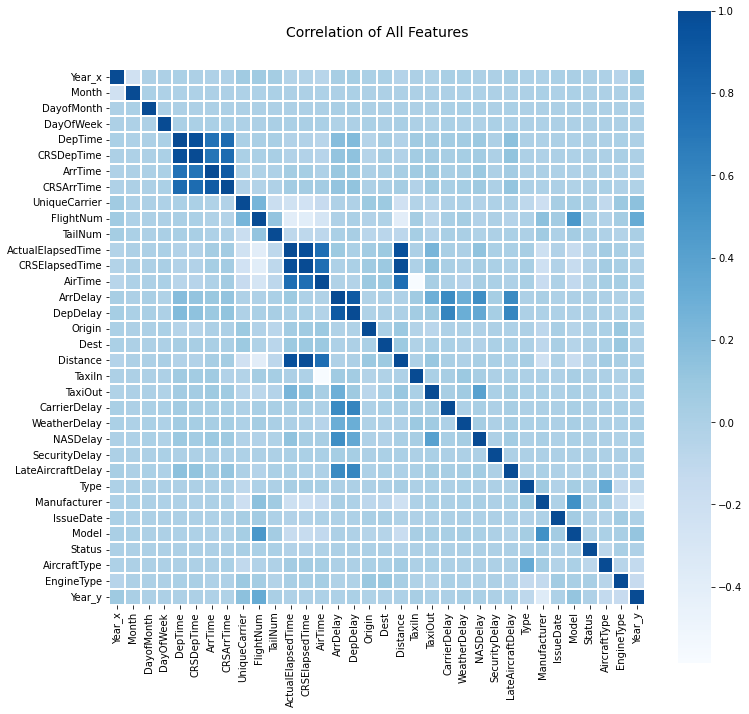

In [30]:
plt.figure(figsize=(12,12))

sns.heatmap(df.corr(), linewidth=0.1,
            cmap='Blues', linecolor='white', square=True, fmt='.2f', center=.3 ,annot=False)

plt.title('Correlation of All Features', y=1.05, size=14)

In [31]:
# highest correlation with ArrDelay are DepDelay,Carrier Delay and Late Aircraft Delay

In [59]:
df = FullData.drop(columns = ['Cancelled', 'Diverted','Year_x','Month','DayofMonth','DayOfWeek',
                             'DepTime','CRSDepTime','ArrTime','CRSArrTime','TailNum','ActualElapsedTime',
                              'CRSElapsedTime','AirTime','Distance','TaxiIn','TaxiOut','IssueDate','WeatherDelay',
                             'SecurityDelay','Type','Year_y','Model','Dest','FlightNum'])

In [60]:
df.columns

Index(['UniqueCarrier', 'ArrDelay', 'DepDelay', 'Origin', 'CarrierDelay',
       'NASDelay', 'LateAircraftDelay', 'Manufacturer', 'Status',
       'AircraftType', 'EngineType'],
      dtype='object')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782426 entries, 0 to 8867910
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   UniqueCarrier      int64  
 1   FlightNum          int64  
 2   ArrDelay           float64
 3   DepDelay           float64
 4   Origin             int64  
 5   Dest               int64  
 6   CarrierDelay       float64
 7   NASDelay           float64
 8   LateAircraftDelay  float64
 9   Manufacturer       int64  
 10  Model              int64  
 11  Status             int64  
 12  AircraftType       int32  
 13  EngineType         int32  
 14  DelayLevel         int64  
dtypes: float64(5), int32(2), int64(8)
memory usage: 661.7 MB


In [ ]:
#Preparing data for machine learning

In [61]:
X = df.drop('ArrDelay', axis =1) #drop the 'ArrDelay' column

In [62]:
y = df['ArrDelay']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state = 5)

In [64]:
sc1=StandardScaler()

In [81]:
X_train_sc = sc1.fit_transform(X_train)
X_test_sc = sc1.transform(X_test)

In [ ]:
# Ridge regression, XGBoost regression and lasso regression are used for building models to predict delays.

### 1. Ridge Regression

In [86]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import pandas as pd
from numpy import arange
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error, r2_score

In [88]:
#define cross-validation method to evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
#define model
model = RidgeCV(alphas=arange(0, 1, 0.1), cv=cv, scoring='neg_mean_absolute_error')
#fit model
model.fit(X_train_sc, y_train)
#display lambda that produced the lowest test MSE
print(model.alpha_)

0.0


In [89]:
# make a prediction
predictedValues= model.predict(X_test_sc)
# summarize prediction
print ('MAE:' ,  round(mean_absolute_error(y_test, predictedValues),2))
print ('MSE:' , round(mean_squared_error(y_test, predictedValues),2))
print('RMSE:' , round(np.sqrt(mean_squared_error(y_test, predictedValues)),2))
print ('R2:' , round(r2_score(y_test, predictedValues),2))

MAE: 7.21
MSE: 108.46
RMSE: 10.41
R2: 0.9


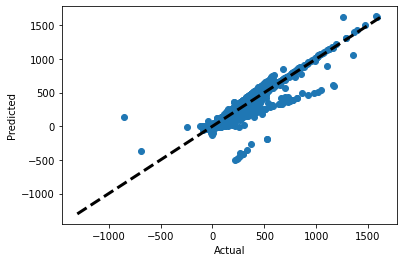

In [90]:
#import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_test, predictedValues)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show() 

### 2. Extreme Gradient Boosting (XGBoost) regression

In [94]:
import xgboost as xgb
import statsmodels.api as sm

In [95]:
#turning training/testing ests into DMatrixes
DM_train=xgb.DMatrix(data=X_train_sc,label=y_train)
DM_test=xgb.DMatrix(data=X_test_sc,label=y_test)

In [96]:
#Parameters for grid search
gbm_param_grid={
    'colsample_bytree': np.linspace(0.7, 0.9, 3),
    'n_estimators':[50,100],
    'max_depth':[3,5],
}

In [97]:
#Instantiate the regressor
gbm=xgb.XGBRegressor()

In [98]:
grid_mse = GridSearchCV(estimator = gbm, param_grid = gbm_param_grid, scoring = 'neg_mean_squared_error', cv = 5, verbose = 1)

In [99]:
grid_mse.fit(X_train_sc, y_train)

print("Best parameters found: ",grid_mse.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters found:  {'colsample_bytree': 0.9, 'max_depth': 5, 'n_estimators': 100}
Lowest RMSE found:  8.23096697502714


In [100]:
predictedValues=grid_mse.predict(X_test_sc)

# summarize prediction
print ('MAE:' ,  round(mean_absolute_error(y_test, predictedValues),2))
print ('MSE:' , round(mean_squared_error(y_test, predictedValues),))
print('RMSE:' , round(np.sqrt(mean_squared_error(y_test, predictedValues)),2))
print ('R2:' , round(r2_score(y_test, predictedValues),2))

MAE: 6.78
MSE: 175
RMSE: 13.22
R2: 0.84


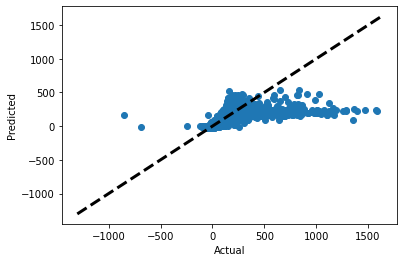

In [102]:
#import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_test, predictedValues)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show() 

### 3. Lasso Regression

In [91]:
# evaluate an lasso regression model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso

model = Lasso(alpha=1.0)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 7.228 (0.010)


In [92]:
# fit model
model.fit(X_train_sc, y_train)
# make a prediction
predictedValues= model.predict(X_test_sc)
# summarize prediction
print ('MAE:' ,  round(mean_absolute_error(y_test, predictedValues),2))
print ('MSE:' , round(mean_squared_error(y_test, predictedValues),))
print('RMSE:' , round(np.sqrt(mean_squared_error(y_test, predictedValues)),2))
print ('R2:' , round(r2_score(y_test, predictedValues),2))

MAE: 7.43
MSE: 111
RMSE: 10.55
R2: 0.9


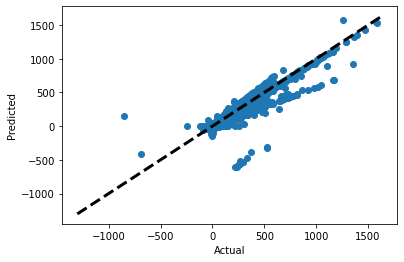

In [93]:
#import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(y_test, predictedValues)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
plt.show() 